In [40]:
%matplotlib inline
from modsim import *
import numpy as np

In [66]:
"""  Team 4

    h: heat transfer coefficient, 10 in this case, for static air cooling
    (related website: https://link.springer.com/article/10.1007/s00231-015-1652-x)
    k_f: the cryoscopic constant, For water, KF = 1.853 K·kg/mol;
    num_ions: the van 't Hoff factor (number of ion particles per individual molecule of solute, e.g. i = 2 for NaCl, 3 for BaCl2).
    (related website: https://en.wikipedia.org/wiki/Freezing-point_depression)
    
    max_soluability for NaCl: 35.65g/mol = 6.15 mole/kg
    A: 686.966 cm^2 = 0.0686966 m^2, surface area of a 500mL water bottle
    (related website: https://www.bottleyourbrand.com/answers/sizing/arrowhead-water-bottle-label-size
    
    T_init: -25Celsius, Initial Temperature of the water bottle, set in Northern Siberia
    (related website: https://en.wikipedia.org/wiki/Siberia)
    k_water: 0.0387
    (related_website: http://jwilson.coe.uga.edu/EMAT6680Fa2014/Gieseking/Exploration%2012/Newton%27s%20Law%20of%20Cooling.htm)
    k_ice: twice k_water
"""
k_f = 1.853 #K*Kg/mol
num_ions = 2 #Number of Ions in NaCl
A = 0.0686966
T_init = -25
T_env = 20
T_end = 4 #Temprature 
latent_heat = 334
h = 10
k_water, k_ice = 0.0384, 0.0774
molality_array = linspace(0, 6.147, 10)
freezing_point_array = 0 - molality_array * k_f * num_ions
freezing_point_array

array([  0.      ,  -2.531198,  -5.062396,  -7.593594, -10.124792,
       -12.65599 , -15.187188, -17.718386, -20.249584, -22.780782])

# Newton's cooling
The section below employs Newton's cooling to calculate temperature

In [55]:
ice = System(T_init=-25, T_env=20, T_end=4, k=k_ice, T=0)
water = System(T_init=0, T_env=20, T_end=4, k=k_water, T=0)

def newton_cooling(system, t):
    """Calculates the change in temperature over time"""
    e=2.71828
    T=system.T
    T = system.T_env + (system.T_init - system.T_env)*e**(-system.k*t)
    
    system.T=T
    return system.T

def run_simulation(system, t):
    results=TimeSeries()
    for i in range(t):
        x=newton_cooling(system, i)
        results[i]=x
    return results

run_simulation(ice, 50)

,value
0,-25.000000
1,-21.648383
2,-18.546396
3,-15.675445
4,-13.018325
5,-10.559107
6,-8.283053
7,-6.176521
8,-4.226884
9,-2.422456


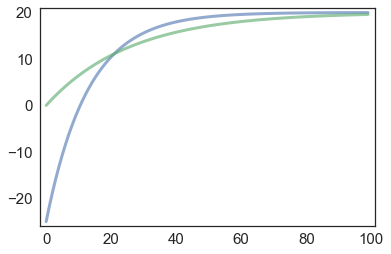

In [8]:
def plot_results(system, t):
    y=run_simulation(system, t)
    plot(y)
    
plot_results(ice, 100)
plot_results(water, 100)

# Melting
The section below calculates the time it takes for water at each salt level to melt

In [9]:
def melting_at(T_fpt):
    dQ = 500 * latent_heat
    dt = dQ / (10 * A *(T_fpt - T_env))
    return -dt

melting_at(0)

12154.895584352065

In [22]:
def get_melting_time(freezing_point_array, update_func):
    arrary_length = len(freezing_point_array)
    sweep_fpt = TimeFrame(index = freezing_point_array, columns=['Time'])
    #sweep_fpt.columns('Time(s)')
    for i in range(0, arrary_length):
        sweep_fpt.loc[freezing_point_array[i]] = update_func(freezing_point_array[i])
    return sweep_fpt

In [23]:
len(freezing_point_array)

10

In [24]:
results_in_seconds = get_melting_time(freezing_point_array, melting_at)
results_in_seconds

,Time
0.000000,12154.895584
-2.531198,10789.391300
-5.062396,9699.707549
-7.593594,8809.940151
-10.124792,8069.695940
-12.655990,7444.205847
-15.187188,6908.705285
-17.718386,6445.077255
-20.249584,6039.762093
-22.780782,5682.409258


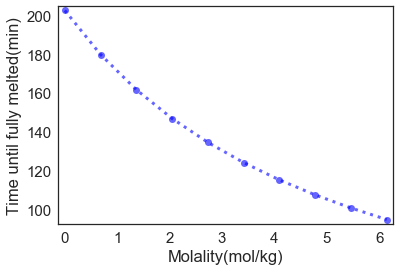

In [44]:
plot(molality_array, results_in_seconds/60, 'bo:')
decorate(xlabel = 'Molality(mol/kg)',
         ylabel = 'Time until fully melted(min)',
         legend = False)

In [38]:
a = np.array(results_in_seconds.Time.values)
np.diff(results_in_seconds.Time.values)

array([-1365.50428403, -1089.68375093,  -889.76739853,  -740.24421115,
        -625.49009303,  -535.50056204,  -463.62803008,  -405.31516193,
        -357.35283496])

In [39]:
results_in_seconds.Time.values

array([ 12154.89558435,  10789.39130032,   9699.70754939,   8809.94015086,
         8069.69593971,   7444.20584668,   6908.70528463,   6445.07725455,
         6039.76209262,   5682.40925767])

# Newton's Cooling(stop at Freezing Pts)

In [69]:
def run_simulation_ice(system, t, freezing_point_array):
    results=TimeSeries()
    for freezing_pt in freezing_point_array:
        recorded = False
        for i in range(t):
            x=newton_cooling(system, i)
            if x > freezing_pt and not recorded:
                results[freezing_pt] = i
                recorded = True
    return results

In [70]:
ice = System(T_init=-25, T_env=20, T_end=4, k=k_ice, T=0)
%time run_simulation_ice(ice, 100, freezing_point_array)

Wall time: 143 ms


,value
0.000000,11
-2.531198,9
-5.062396,8
-7.593594,7
-10.124792,6
-12.655990,5
-15.187188,4
-17.718386,3
-20.249584,2
-22.780782,1


In [32]:
coffee = make_system_coffee()
run_simulation(coffee, update)

In [24]:
coffee.results.temp[30]

67.584544488161882

In [37]:
def update(state, system, t, T_sweep):
    unpack(system)
    if 5 < t < 30:
        T_amb = T_sweep
    else:
        T_amb = T_env
    T = state.temp
    T += -r * (T - T_amb) * dt

    return State(temp=T)

In [38]:
def run_simulation_sweep(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    ts = linrange(t0, t_end-dt, dt)
    sweep = SweepSeries()
    for T_sweep in linrange(0, 21):
        frame = TimeFrame(columns=init.index)
        frame.loc[t0] = init
        for t in ts:
            frame.loc[t+dt] = update_func(frame.loc[t], system, t, T_sweep)
        sweep[T_sweep] = frame.temp[t_end]
    
    system.results = sweep

In [39]:
coffee = make_system_coffee()
run_simulation_sweep(coffee, update)

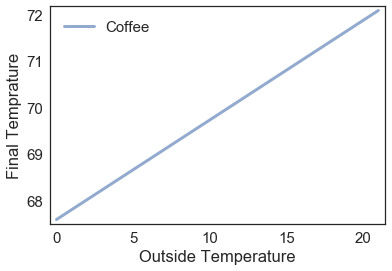

In [46]:
plot(coffee.results, label = 'Coffee')
decorate(xlabel = 'Outside Temperature',
         ylabel = 'Final Temprature',
         legend = 'True')

In [78]:
def run_and_mix(t_add, t_total=30):
    coffee = make_system(T_init=90, t_end=t_add, 
                         r=r_coffee, volume=300)
    run_simulation(coffee, update)

    milk = make_system(T_init=5, t_end=t_add, 
                       r=r_milk, volume=50)
    run_simulation(milk, update)
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    run_simulation(mixture, update)

    return final_temp(mixture)

def mix(s1, s2):
    assert s1.t_end == s2.t_end
    
    volume = s1.volume + s2.volume
    
    temp = (s1.volume * final_temp(s1) + 
            s2.volume * final_temp(s2)) / volume
    
    mixture = make_system(T_init=temp,
                          volume=volume,
                          r=s1.r,
                          t_end = s1.t_end)
    return mixture

def make_system(T_init=90, r=0.01, volume=300, t_end=30):
    init = State(temp=T_init)
    
    system = System(init=init,
                    volume=volume,
                    r=r,
                    T_env=22, 
                    t0=0,
                    t_end=t_end,
                    dt=1)
    return system

def final_temp(system):
    if hasattr(system, 'results'):
        return system.results.temp[system.t_end]
    else:
        return system.init.temp

In [89]:
def run_simulation_sweep(s1, s2, update_func):
    system = mix(s1, s2)
    unpack(system)
    ts = linrange(t0, t_end-dt, dt)
    sweep = SweepSeries()
    for T_sweep in linrange(0, 21):
        frame = TimeFrame(columns=init.index)
        frame.loc[t0] = init
        for t in ts:
            frame.loc[t+dt] = update_func(frame.loc[t], system, t, T_sweep)
        sweep[T_sweep] = frame.temp[t_end]
    
    return sweep

In [90]:
milk = make_system_milk()
coffee = make_system_coffee()

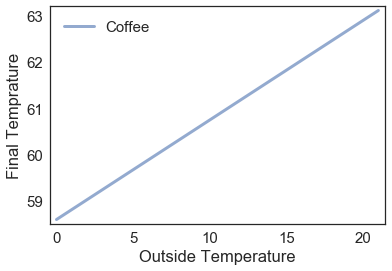

In [91]:
plot(run_simulation_sweep(coffee, milk, update), label = 'Coffee')
decorate(xlabel = 'Outside Temperature',
         ylabel = 'Final Temprature',
         legend = True)